In [1]:
import numpy as np
from scipy.stats import ks_2samp, ks_1samp, kstest
import json
import pandas as pd
import matplotlib.pyplot as plt
from random import choices
import os

In [2]:
import re
def match_regex_array(files, regex):
    matches = [re.findall(regex, f) for f in files]
    matches = ["./sim_results/" + m[0] for m in matches if len(m) > 0 ]
    return matches

In [3]:
# Apply KS-test using a large number of samples from the reference distribution 
# and a small sample from a "test" (in this case, the Network-Aware) distribution multiple times
# Each test sample represents a bot consuming contents from NA-distribution
# Function returns the mean of the p_values for all KS-tests performed for each bot
# and the proportion of null hypothesis rejection, i.e., samples were not generated from the same distribution
def covertness_kstest(ref_dist, test_dist, population, ref_dist_size=10**6, test_dist_size=10**3, N_bots = 100, rounds=30):
    p_values_mean_rounds = []
    rejection_proportions_rounds = []
    ref_dist_large_samples = choices(population, ref_dist, k=ref_dist_size)
    for i in range(rounds):
        p_values = []        
        null_hypothesis_rejections = 0
        for j in range(N_bots):
            test_dist_samples = choices(population, test_dist, k=test_dist_size) # bot "watches" amount of contents
            ks = ks_2samp(ref_dist_large_samples, test_dist_samples)
            p_values.append(ks.pvalue)
            if (ks.pvalue < 0.05):
                null_hypothesis_rejections += 1
        p_values_mean = np.mean(p_values)
        null_hypothesis_rejections /= N_bots

        p_values_mean_rounds.append(p_values_mean)
        rejection_proportions_rounds.append(np.mean(null_hypothesis_rejections))
    return p_values_mean_rounds, rejection_proportions_rounds

In [5]:
# aggregated mode
def covertness_kstest_aggregate(baseline_samples, test_dist, population, test_dist_size=10**3, N_bots = 100, rounds=30):
    p_values_rounds = []
    null_hypothesis_rejections = 0
    for i in range(rounds):
        # print("round ", i, end=' ')
        test_agg_samples = []
        for j in range(N_bots):
            test_dist_samples = choices(population, test_dist, k=test_dist_size) # bot "watches" amount of contents
            test_agg_samples += test_dist_samples
        ks = ks_2samp(baseline_samples, test_agg_samples)
        if (ks.pvalue < 0.05):
            null_hypothesis_rejections += 1
        p_values_rounds.append(ks.pvalue)        
    return p_values_rounds, null_hypothesis_rejections/rounds

In [6]:
data_lastfm = json.load(open("./sim_results/sim_results_Ulastfm_pop0_a0.5_N2_C5_CPtop_Q0.5_L40.json"))
lastfm_size = len(data_lastfm['p0'])
data_movielens = json.load(open("./sim_results/sim_results_Umovielens1k_pop1_a0.5_N2_C10_CPtop_Q0.9_L40.json"))
movielens_size = len(data_movielens['p0'])
population_movielens = np.arange(movielens_size)
population_lastfm = np.arange(lastfm_size)

In [9]:
# Consistency Check - we should see a small p-value when comparing samples from pi_NA 
# and a high p-value when using samples from pi_bs
# print("KStest between large samples bs and a small sample bs (expected high p-value)")
# p_values_means, proportion_means = covertness_kstest(data_movielens['pi_bs'], data_movielens['pi_bs'], population_movielens, ref_dist_size=10**3, test_dist_size=10**2, N_bots=20)
# print("p_value: " ,np.mean(p_values_means))
# print(np.mean(proportion_means))
print("KStest between large samples bs and a small sample NA (expected low p-value)")
baseline_samples = choices(population_movielens, data_movielens['pi_bs'], k=10**4)
p_values, proportion = covertness_kstest_aggregate(baseline_samples, data_movielens['pi_final_NA'], population_movielens, test_dist_size=20, N_bots=10, rounds=30)
proportion
# print("p_value: ", np.mean(p_values_means))
# print(np.mean(proportion_means))


KStest between large samples bs and a small sample NA (expected low p-value)


0.6

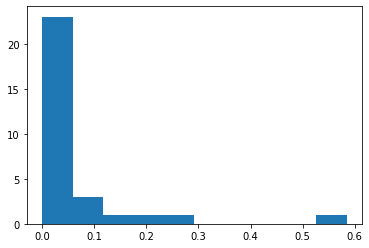

In [10]:
# It should have the shape of a normal distribution
plt.hist(p_values)
plt.show()

In [12]:
# It should have the shape of a normal distribution
# plt.hist(proportion_means)
# plt.show()

In [14]:
def ci_proportion(p_hat, n):
    std_hat = np.sqrt((p_hat*(1-p_hat))/n)
    lower = p_hat - 1.96*std_hat
    upper = p_hat + 1.96*std_hat
    return lower, p_hat, upper

In [55]:
from os.path import exists
def save_confidence_intervals(cis, test_dist_sizes, rounds, bots):
    filename = "confidence_interval_" + "tds" + str(test_dist_sizes[0]) + \
        "-" + str(test_dist_sizes[-1]) + "_rounds_" + str(rounds) + \
        "_bots_" + str(bots) + ".txt"
    if (not exists(filename)):
        lowers = np.array([cis[i][0] for i in range(len(cis))])
        means = np.array([cis[i][1] for i in range(len(cis))])
        uppers = np.array([cis[i][2] for i in range(len(cis))])
        f = open(filename, "w")
        n_intervals = len(means)
        for i in range(n_intervals):            
            f.write(str(lowers[i]) + "," + str(means[i]) + "," + \
                    str(uppers[i]) + str(test_dist_sizes[i]) + "\n")
        f.close()
    else:
        print("{} file already exists".format(filename))
    

In [ ]:
test_dist_sizes = np.linspace(10, 50, 40).astype(int)
proportions = []
confidence_intervals = []
ref_dist_size=10**4
ref_dist = data_movielens['pi_bs']
ref_dist_samples = choices(population_movielens, ref_dist, k=ref_dist_size)
nrounds = 100
n_bots = [10, 20, 30]
for nbots in n_bots:
    cis = []
    for tds in test_dist_sizes:
        print(tds, end=',')
        p_values, proportion = covertness_kstest_aggregate(ref_dist_samples, data_movielens['pi_final_NA'], population_movielens, test_dist_size=tds, N_bots=nbots, rounds=nrounds)
        proportions.append(proportion)
        cis.append(np.array(ci_proportion(proportion, nrounds)))
    save_confidence_intervals(cis, test_dist_sizes, nrounds, nbots)

10,

In [56]:
save_confidence_intervals(cis, test_dist_sizes, nrounds, nbots)

In [82]:
def plot_confidence_intervals(x, filename):
    try:
        f = open(filename, "r")
        cis = np.array([np.array(line.rstrip().split(",")).astype(float) for line in f.readlines()])
        lowers = cis[:, 0]
        means = cis[:, 1]
        uppers = cis[:, 2]
        fig, ax = plt.subplots()
        ax.plot(x, means)
        ax.fill_between(x, lowers, uppers, color='b', alpha=.1)
        plt.xlabel("Contents per bot")
        plt.ylabel("Proportion of null hypothesis rejections")
        # plt.savefig("proportions_nbots30.png")
        plt.show()
    except Exception as e:
        print(e)

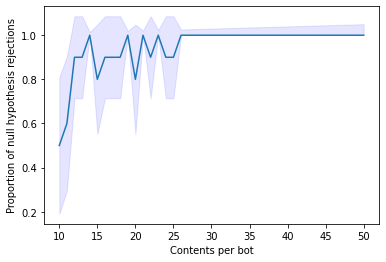

In [85]:
plot_confidence_intervals(test_dist_sizes, "confidence_interval_tds10-50_rounds_10_bots_30.txt")

In [23]:
# for the not aggregated case
# test_dist_sizes = np.linspace(10, 40, 4).astype(int)
# pvalues_mean_sample = []
# proportion_mean_sample = []
# confidence_intervals = []
# for tds in test_dist_sizes:
#     print(tds)
#     p_values_means, proportion_means = covertness_kstest(data_movielens['pi_bs'], data_movielens['pi_final_NA'], population_movielens, ref_dist_size=10**4, test_dist_size=tds, N_bots=50, rounds=30)
#     pvalues_mean_sample.append(p_values_means)
#     proportion_mean_sample.append(proportion_means)

In [ ]:
files = os.listdir('./sim_results/')
movielens_simulations_files = match_regex_array(files, r'sim_results_Umovielens.*')
lastfm_simulations_files = match_regex_array(files, r'sim_results_Ulastfm.*')
ks_movielens = []
i = 0
end = movielens_size
for filename in movielens_simulations_files:
    print("{}/{}".format(i, end))
    kstest_file(filename)
    i+=1

0/1060
1/1060
2/1060
3/1060
4/1060
5/1060
6/1060
7/1060
8/1060
9/1060
10/1060
11/1060
12/1060
13/1060
14/1060
15/1060
16/1060


In [139]:
from scipy import stats
rv = stats.expon(scale=1/0.247)
rv.cdf(0.7)

0.1587782671880641

In [178]:
exp_samples = stats.expon(scale=1/0.247).rvs(size=10**6)

In [179]:
ks_1samp(exp_samples, stats.expon(scale=1/0.247).cdf)

KstestResult(statistic=0.000453357937850285, pvalue=0.9862728719610566)

In [181]:
# it seems that KStest doesn't work very well for discrete cdf. p value not making sense. It should be high.
def cdf_(X):
    if (type(X) == int):        
        r = sum(data_movielens['pi_bs'][:X])
    else:
        r = [sum(data_movielens['pi_bs'][:x]) for x in X]
    return r
population = np.arange(movielens_size)
samples = choices(population, data_movielens['pi_bs'], k=10**6)
ks_1samp(samples, cdf_)